# Shared vision model

mnist의 두 샘플 이미지가 같은 숫자인지 분류하는 문제를 다룬다. 이미지 처리를 위하여 vision_model을 이용하고 이 모델은 두 이미지 처리에 공유된다.

모델 구성의 작동 여부에만 초점을 두어 불균형 데이터 문제나 성능 개선에 대한 검토는 하지 않고. 과적합에 대비하여 epochs 수만 조절한다.

https://keras.io/getting-started/functional-api-guide/ 문서의 Shared vision model을 참고하였다.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danhojin/ml-notes/blob/master/dl/mnist_digit_pairs_keras_shared_vision_model.ipynb)

## importing modules and preparing datasets

In [1]:
import random

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0
x_train.shape

(60000, 28, 28, 1)

In [3]:
index_1 = list(range(x_train.shape[0]))
random.shuffle(index_1)
index_2 = list(range(x_train.shape[0]))
random.shuffle(index_2)

df = pd.DataFrame({
    'index_1': index_1,
    'index_2': index_2
})

df['y'] = y_train[df['index_1']] - y_train[df['index_2']]
df['y'] = df['y'].apply(lambda x: 1 if x == 0 else 0)

df.head()

,index_1,index_2,y
0,44210,39485,1
1,3662,1901,0
2,38414,13146,0
3,16455,24663,1
4,31387,19946,0


In [4]:
df['y'].sum()  # unbalanced dataset 10%

6000

## model

In [5]:
digit_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (3, 3))(digit_inputs)
x = layers.Conv2D(64, (3, 3))(x)
x = layers.MaxPooling2D((2, 2))(x)
digit_outputs = layers.Flatten()(x)

vision_model = models.Model(inputs=digit_inputs, outputs=digit_outputs)

vision_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
_________________________________________________________________


In [6]:
digit_a = layers.Input(shape=(28, 28, 1))
digit_b = layers.Input(shape=(28, 28, 1))

encoded_a = vision_model(digit_a)
encoded_b = vision_model(digit_b)

x = layers.concatenate([encoded_a, encoded_b])
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[digit_a, digit_b], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 9216)         37568       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 18432)        0           model[1][0]                

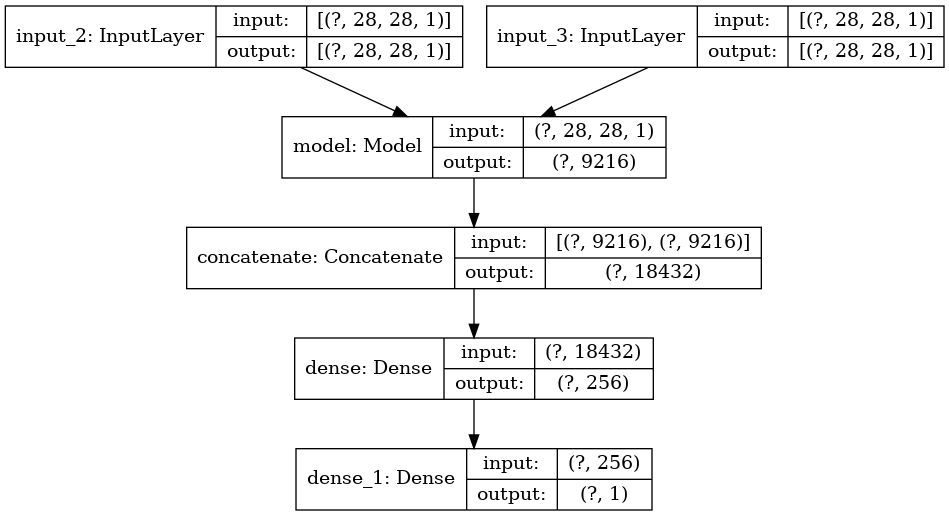

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

## fitting

In [8]:
model.save_weights('init_weights.h5')

batch_size = 64
epochs = 15

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(
    [x_train[df['index_1']], x_train[df['index_2']]],
    df['y'].values,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.4,
    verbose=0,
)


In [9]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [10]:
hdf = pd.DataFrame({
    'dataset': ['train'] * epochs + ['val'] * epochs,
    'loss': history.history['loss'] + history.history['val_loss'],
    'acc': history.history['acc'] + history.history['acc'],
    'epoch': list(range(1, epochs + 1)) + list(range(1, epochs + 1))
})
p1 = alt.Chart(hdf).mark_line().encode(
    x='epoch',
    y='loss',
    color='dataset'
)
p2 = alt.Chart(hdf).mark_line().encode(
    x='epoch',
    y=alt.Y('acc', scale=alt.Scale(domain=(0.9, 1.0))),
    color='dataset'
)
p1 & p2

alt.VConcatChart(...)

In [11]:
K.clear_session()
model.load_weights('init_weights.h5')

epochs = 5
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(
    [x_train[df['index_1']], x_train[df['index_2']]],
    df['y'].values,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.4,
    verbose=1,
)

Train on 36000 samples, validate on 24000 samples
Epoch 1/5
36000/36000 [==============================] - 5s 135us/sample - loss: 0.2694 - acc: 0.9071 - val_loss: 0.1824 - val_acc: 0.9272
Epoch 2/5
36000/36000 [==============================] - 4s 122us/sample - loss: 0.1439 - acc: 0.9418 - val_loss: 0.1291 - val_acc: 0.9510
Epoch 3/5
36000/36000 [==============================] - 4s 122us/sample - loss: 0.0876 - acc: 0.9654 - val_loss: 0.1154 - val_acc: 0.9587
Epoch 4/5
36000/36000 [==============================] - 4s 122us/sample - loss: 0.0514 - acc: 0.9807 - val_loss: 0.1258 - val_acc: 0.9582
Epoch 5/5
36000/36000 [==============================] - 4s 122us/sample - loss: 0.0292 - acc: 0.9890 - val_loss: 0.1571 - val_acc: 0.9581


In [12]:
hdf = pd.DataFrame({
    'dataset': ['train'] * epochs + ['val'] * epochs,
    'loss': history.history['loss'] + history.history['val_loss'],
    'acc': history.history['acc'] + history.history['acc'],
    'epoch': list(range(1, epochs + 1)) + list(range(1, epochs + 1))
})
p1 = alt.Chart(hdf).mark_line().encode(
    x='epoch',
    y='loss',
    color='dataset'
)
p2 = alt.Chart(hdf).mark_line().encode(
    x='epoch',
    y=alt.Y('acc', scale=alt.Scale(domain=(0.9, 1.0))),
    color='dataset'
)
p1 & p2

alt.VConcatChart(...)

## predict

In [13]:
imgs = random.choices(range(10000), k=2)

results = model.predict([
    x_test[imgs[0]].reshape((-1, 28, 28, 1)),
    x_test[imgs[1]].reshape((-1, 28, 28, 1))])

y_test[imgs], results

(array([9, 4], dtype=uint8), array([[0.03356259]], dtype=float32))

In [24]:
imgs = random.choices(range(10000), k=2)

results = model.predict([
    x_test[imgs[0]].reshape((-1, 28, 28, 1)),
    x_test[imgs[1]].reshape((-1, 28, 28, 1))])

y_test[imgs], results

(array([3, 3], dtype=uint8), array([[0.99395627]], dtype=float32))